In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Check cuda version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
%tensorflow_version 2.x
!pip install gast==0.2.2
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=d159201611d5d796a280a9b136745c03ee6d3bf7b87e7304018d0c8c60b0ad99
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Looking in indexe

In [ ]:
%cd gdrive/MyDrive/Mini-Project/snip

/content/gdrive/MyDrive/Mini-Project/snip


# Comparisons under Varied Sparsity

In [ ]:
import os
import sys
import argparse
import tensorflow as tf

from dataset import Dataset
from model import Model
import prune
import train
import test

arch = 'lenet300'
batch_size = 500
datasource = 'mnist'
decay_boundaries = [5000, 10000, 15000, 20000, 25000]
if arch == 'lenet300':
    decay_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
elif arch == 'lenet5':
    decay_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
target_sparsity = 0
train_iterations = 30000

class Args:
    def __init__(self, arch, 
                 batch_size, 
                 datasource, 
                 decay_boundaries, 
                 decay_values, 
                 target_sparsity, 
                 train_iterations, 
                 iter):
        self.arch = arch
        self.aug_kinds = ['fliplr', 'translate_px']
        self.batch_size = batch_size
        self.check_interval = 1000
        self.datasource = datasource
        self.decay_boundaries = decay_boundaries
        self.decay_values = decay_values
        self.initializer_b_ap = 'zeros'
        self.initializer_b_bp = 'zeros'
        self.initializer_w_ap = 'vs'
        self.initializer_w_bp = 'vs'
        self.logdir = './VariedSparsity/iter' + str(iter)
        self.lr = 0.1
        self.lr_decay_type = 'piecewise'
        self.optimizer = 'momentum'
        self.path_assess = self.logdir + '/assess'
        self.path_data = '/content/gdrive/MyDrive/Mini-Project/'
        self.path_model = self.logdir + '/model'
        self.path_summary = self.logdir + '/summary'
        self.save_interval = 1000
        self.target_sparsity = target_sparsity
        self.train_iterations = train_iterations
        self.is_sample = False
        self.sample_class = 0

for iter in range(0, 10):
    # Set arguments
    print("|--------- ITERATION {} ---------|".format(iter))
    args = Args(arch, batch_size, datasource, decay_boundaries, decay_values, target_sparsity, train_iterations, iter)

    # Dataset
    dataset = Dataset(**vars(args))

    # Reset the default graph and set a graph-level seed
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    tf.reset_default_graph()
    tf.set_random_seed(iter)

    # Model
    model = Model(num_classes=dataset.num_classes, **vars(args))
    model.construct_model()

    # Session
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()

    # Prune
    prune.prune(args, model, sess, dataset)

    # Train and test
    train.train(args, model, sess, dataset)
    test.test(args, model, sess, dataset)

    sess.close()

# Comparisons with Various Modern Architectures

## MNIST and KMNIST

In [ ]:
! python main.py --logdir './VariousArchitectures' --arch lenet5 --target_sparsity 0.9 --datasource mnist --path_data '/content/gdrive/MyDrive/Mini-Project/' --aug_kinds fliplr translate_px --batch_size 100 --train_iterations 150000 --optimizer momentum --lr_decay_type piecewise --decay_boundaries 25000 50000 75000 100000 125000 --decay_values 1e-2 1e-3 1e-4 1e-5 1e-6 1e-7

## CIFAR-10

In [ ]:
! python main.py --logdir './VariousArchitectures' --arch vgg-like --target_sparsity 0.97 --datasource cifar-10 --path_data '/content/gdrive/MyDrive/Mini-Project/' --aug_kinds fliplr translate_px --batch_size 512 --train_iterations 37500 --optimizer momentum --lr_decay_type piecewise --decay_boundaries 7500 15000 22500 30000 --decay_values 1e-1 1e-2 1e-3 1e-4 1e-5

# Understanding Which Connections Are Being Pruned

In [ ]:
import os
import sys
import argparse
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

from dataset import Dataset
from model import Model

arch = 'lenet300'
datasource = 'kmnist'
if datasource == 'cifar-10':
    batch_size = 512
    decay_boundaries = [7500, 15000, 22500, 30000]
    decay_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    train_iterations = 37500
elif 'mnist' in datasource:
    batch_size = 500
    decay_boundaries = [5000, 10000, 15000, 20000, 25000]
    if arch == 'lenet300':
        decay_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
    elif arch == 'lenet5':
        decay_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
    train_iterations = 30000

class Args:
    def __init__(self, arch, 
                 batch_size, 
                 datasource, 
                 decay_boundaries, 
                 decay_values, 
                 target_sparsity, 
                 train_iterations, 
                 iter,
                 sample_class):
        self.arch = arch
        self.aug_kinds = ['fliplr', 'translate_px']
        self.batch_size = batch_size
        self.check_interval = 1000
        self.datasource = datasource
        self.decay_boundaries = decay_boundaries
        self.decay_values = decay_values
        self.initializer_b_ap = 'zeros'
        self.initializer_b_bp = 'zeros'
        self.initializer_w_ap = 'vs'
        self.initializer_w_bp = 'vs'
        self.logdir = './WeightsPruned/iter' + str(iter)
        self.lr = 0.1
        self.lr_decay_type = 'piecewise'
        self.optimizer = 'momentum'
        self.path_assess = self.logdir + '/assess'
        self.path_data = '/content/gdrive/MyDrive/Mini-Project/'
        self.path_model = self.logdir + '/model'
        self.path_summary = self.logdir + '/summary'
        self.save_interval = 1000
        self.target_sparsity = target_sparsity
        self.train_iterations = train_iterations
        self.is_sample = False
        self.sample_class = sample_class

images = np.zeros((9, 10, 28, 28))

for sample_class in range(0, 10):
    print("|--------- Sample class {} ---------|".format(sample_class))
    for target_sparsity in range(1, 10):
        print("|--------- Target sparsity {} ---------|".format(target_sparsity * 0.1))

        # Set arguments
        args = Args(arch, batch_size, datasource, decay_boundaries, decay_values, target_sparsity * 0.1, train_iterations, iter, sample_class)

        # Dataset
        args.is_sample = True
        sampleset = Dataset(**vars(args))

        # Reset the default graph and set a graph-level seed
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        tf.reset_default_graph()
        tf.set_random_seed(9)

        # Model
        model = Model(num_classes=dataset.num_classes, **vars(args))
        model.construct_model()

        # Session
        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()

        # Prune
        print('|========= START PRUNING =========|')
        t_start = time.time()
        batch = sampleset.get_next_batch('train', 100)
        feed_dict = {}
        feed_dict.update({model.inputs[key]: batch[key] for key in ['input', 'label']})
        feed_dict.update({model.compress: True, model.is_train: False, model.pruned: False})
        result = sess.run([model.outputs, model.sparsity, model.mask['w1']], feed_dict)
        print('Pruning: {:.3f} global sparsity (t:{:.1f})'.format(result[1], time.time() - t_start))

        w1_mask = np.array(result[-1])
        image = np.reshape(np.mean(w1_mask, axis=1), (28, 28))
        images[target_sparsity-1, sample_class] = image

        sess.close()

|--------- Sample class 0 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.2)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 1 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 2 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.2)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 3 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 4 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.2)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.2)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 5 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 6 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.2)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 7 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 8 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|--------- Sample class 9 ---------|
|--------- Target sparsity 0.1 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|--------- Target sparsity 0.2 ---------|
# Parameters: 2.67e+05 -> 2.13e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.200 global sparsity (t:0.1)
|--------- Target sparsity 0.30000000000000004 ---------|
# Parameters: 2.67e+05 -> 1.87e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.300 global sparsity (t:0.1)
|--------- Target sparsity 0.4 ---------|
# Parameters: 2.67e+05 -> 1.60e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.400 global sparsity (t:0.1)
|--------- Target sparsity 0.5 ---------|
# Parameters: 2.67e+05 -> 1.33e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.500 global sparsity (t:0.1)
|--------- Target sparsity 0.6000000000000001 ---------|
# Parameters: 2.67e+05 -> 1.07e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.600 global sparsity (t:0.1)
|--------- Target sparsity 0.7000000000000001 ---------|
# Parameters: 2.67e+05 -> 8.00e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.700 global sparsity (t:0.1)
|--------- Target sparsity 0.8 ---------|
# Parameters: 2.67e+05 -> 5.33e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.800 global sparsity (t:0.1)
|--------- Target sparsity 0.9 ---------|
# Parameters: 2.67e+05 -> 2.67e+04
|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


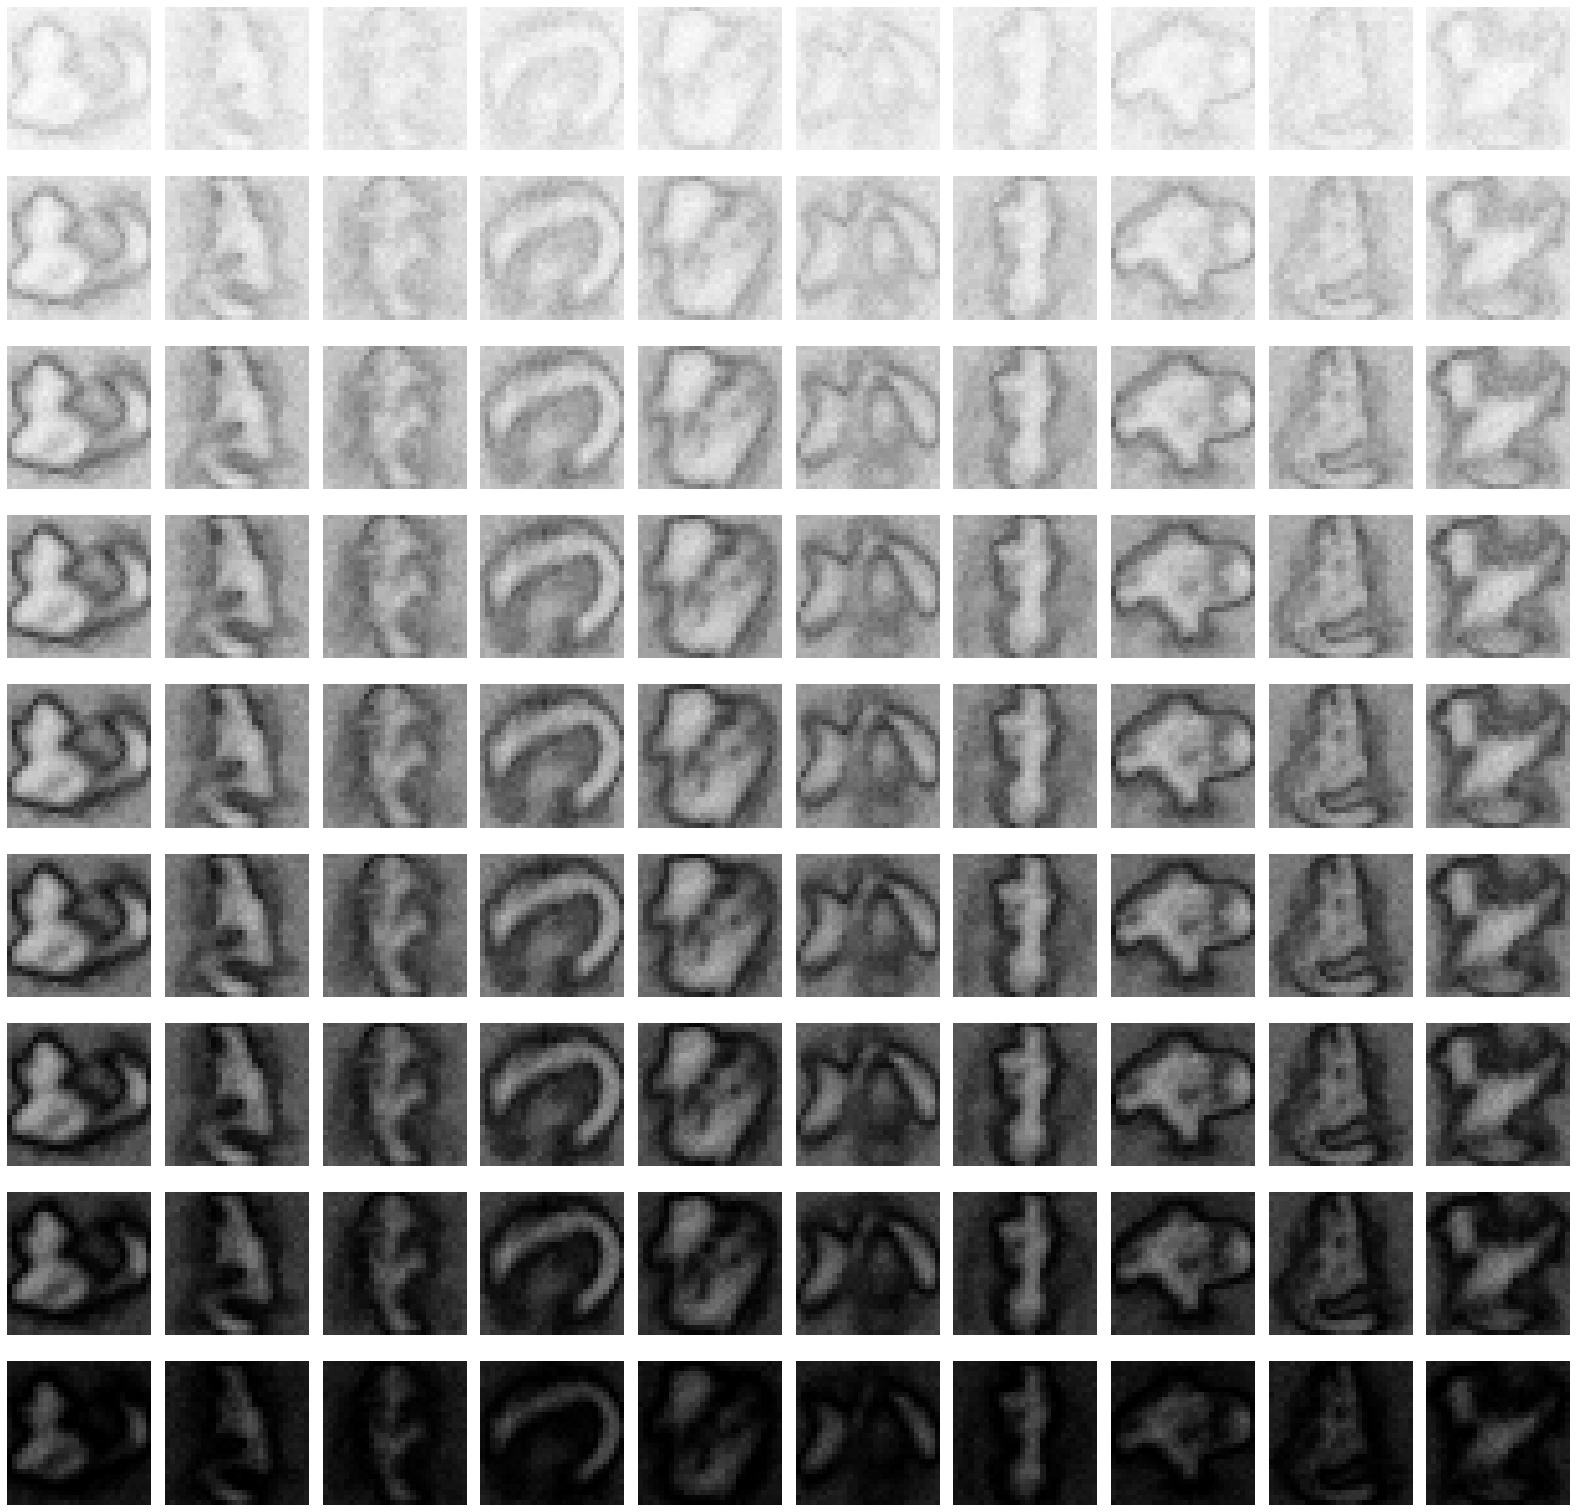

In [ ]:
fig, ax = plt.subplots(nrows=9, ncols=10, figsize=[28, 28], squeeze=True)
fig = plt.subplots_adjust(wspace=0.1, hspace=0.01)

for i, axes in enumerate(ax.flat):
    ir = i // 10
    ic = i % 10
    axes.imshow(images[ir, ic] * 255, cmap='gray', vmin=0, vmax=255)
    axes.axis('off')

# Effects of Data and Batch Sizes
## Effects of Data

In [ ]:
import os
import sys
import argparse
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt

from dataset import Dataset
from model import Model
import train
import test

arch = 'lenet300'
batch_size = 500
datasource = 'kmnist'
decay_boundaries = [5000, 10000, 15000, 20000, 25000]
if arch == 'lenet300':
    decay_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
elif arch == 'lenet5':
    decay_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
train_iterations = 30000

class Args:
    def __init__(self, arch, 
                 batch_size, 
                 datasource, 
                 decay_boundaries, 
                 decay_values, 
                 target_sparsity, 
                 train_iterations, 
                 iter,
                 sample_class,
                 Db):
        self.arch = arch
        self.aug_kinds = ['fliplr', 'translate_px']
        self.batch_size = batch_size
        self.check_interval = 1000
        self.datasource = datasource
        self.decay_boundaries = decay_boundaries
        self.decay_values = decay_values
        self.initializer_b_ap = 'zeros'
        self.initializer_b_bp = 'zeros'
        self.initializer_w_ap = 'vs'
        self.initializer_w_bp = 'vs'
        self.logdir = './DataEffects/iter' + str(iter) + 'Db' + str(Db)
        self.lr = 0.1
        self.lr_decay_type = 'piecewise'
        self.optimizer = 'momentum'
        self.path_assess = self.logdir + '/assess'
        self.path_data = '/content/gdrive/MyDrive/Mini-Project/'
        self.path_model = self.logdir + '/model'
        self.path_summary = self.logdir + '/summary'
        self.save_interval = 1000
        self.target_sparsity = target_sparsity
        self.train_iterations = train_iterations
        self.is_sample = False
        self.sample_class = sample_class

Dbs = [1, 10, 100, 1000, 10000, 54000]

for iter in range(0, 5):
    print("|--------- iter {} ---------|".format(iter))
    for Db in Dbs:
        print("|--------- |D^b| {} ---------|".format(Db))
        images = np.zeros((6, 28, 28))
        index = 0

        # Set arguments
        args = Args(arch, batch_size, datasource, decay_boundaries, decay_values, 0.9, train_iterations, iter, 0, Db)

        # Dataset
        args.is_sample = False
        dataset = Dataset(**vars(args))

        # Reset the default graph and set a graph-level seed
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        tf.reset_default_graph()
        tf.set_random_seed(9)

        # Model
        model = Model(num_classes=dataset.num_classes, **vars(args))
        model.construct_model()

        # Session
        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()

        # Prune
        print('|========= START PRUNING =========|')
        t_start = time.time()
        batch = dataset.get_next_batch('train', Db)
        feed_dict = {}
        feed_dict.update({model.inputs[key]: batch[key] for key in ['input', 'label']})
        feed_dict.update({model.compress: True, model.is_train: False, model.pruned: False})
        result = sess.run([model.outputs, model.sparsity, model.mask['w1']], feed_dict)
        print('Pruning: {:.3f} global sparsity (t:{:.1f})'.format(result[1], time.time() - t_start))

        w1_mask = np.array(result[-1])
        image = np.reshape(np.mean(w1_mask, axis=1), (28, 28))
        images[index] = image
        index += 1

        # Train and test
        train.train(args, model, sess, dataset)
        test.test(args, model, sess, dataset)

        sess.close()

|--------- iter 0 ---------|
|--------- |D^b| 1 ---------|
# Parameters: 2.67e+05 -> 2.67e+04


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.655/0.685 acc:0.830/0.804 spa:0.900 (t:50.3)
itr2000: (train/val) los:0.645/0.600 acc:0.814/0.846 spa:0.900 (t:50.8)
itr3000: (train/val) los:0.572/0.633 acc:0.854/0.816 spa:0.900 (t:51.6)
itr4000: (train/val) los:0.616/0.612 acc:0.838/0.844 spa:0.900 (t:50.0)
itr5000: (train/val) los:0.659/0.651 acc:0.820/0.842 spa:0.900 (t:51.1)
itr6000: (train/val) los:0.528/0.541 acc:0.870/0.860 spa:0.900 (t:52.1)
itr7000: (train/val) los:0.488/0.448 acc:0.876/0.884 spa:0.900 (t:50.3)
itr8000: (train/val) los:0.450/0.470 acc:0.894/0.872 spa:0.900 (t:52.6)
itr9000: (train/val) los:0.436/0.538 acc:0.888/0.856 spa:0.900 (t:50.9)
itr10000: (train/val) los:0.467/0.544 acc:0.892/0.852 spa:0.900 (t:51.9)
itr11000: (train/val) los:0.510/0.479 acc:0.858/0.868 spa:0.900 (t:51.2)
itr12000: (train/val) los:0.448/0.461 acc:0.884/0.878 spa:0.900 (t:50.6)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.625/0.611 acc:0.830/0.844 spa:0.900 (t:50.9)
itr2000: (train/val) los:0.627/0.632 acc:0.830/0.838 spa:0.900 (t:50.5)
itr3000: (train/val) los:0.612/0.600 acc:0.832/0.828 spa:0.900 (t:51.5)
itr4000: (train/val) los:0.573/0.571 acc:0.860/0.856 spa:0.900 (t:49.7)
itr5000: (train/val) los:0.579/0.616 acc:0.858/0.844 spa:0.900 (t:50.7)
itr6000: (train/val) los:0.553/0.548 acc:0.864/0.864 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.498/0.473 acc:0.876/0.872 spa:0.900 (t:49.6)
itr8000: (train/val) los:0.516/0.494 acc:0.870/0.870 spa:0.900 (t:51.6)
itr9000: (train/val) los:0.434/0.518 acc:0.908/0.876 spa:0.900 (t:50.0)
itr10000: (train/val) los:0.554/0.557 acc:0.868/0.868 spa:0.900 (t:50.5)
itr11000: (train/val) los:0.445/0.428 acc:0.900/0.892 spa:0.900 (t:50.0)
itr12000: (train/val) los:0.493/0.481 acc:0.888/0.888 spa:0.900 (t:49.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.617/0.630 acc:0.824/0.802 spa:0.900 (t:50.6)
itr2000: (train/val) los:0.613/0.600 acc:0.834/0.856 spa:0.900 (t:50.4)
itr3000: (train/val) los:0.522/0.603 acc:0.876/0.844 spa:0.900 (t:51.2)
itr4000: (train/val) los:0.524/0.599 acc:0.878/0.834 spa:0.900 (t:49.6)
itr5000: (train/val) los:0.569/0.587 acc:0.860/0.866 spa:0.900 (t:50.8)
itr6000: (train/val) los:0.516/0.561 acc:0.888/0.866 spa:0.900 (t:51.0)
itr7000: (train/val) los:0.497/0.484 acc:0.874/0.902 spa:0.900 (t:49.5)
itr8000: (train/val) los:0.456/0.464 acc:0.894/0.892 spa:0.900 (t:51.7)
itr9000: (train/val) los:0.423/0.470 acc:0.924/0.892 spa:0.900 (t:50.0)
itr10000: (train/val) los:0.525/0.509 acc:0.874/0.882 spa:0.900 (t:50.8)
itr11000: (train/val) los:0.471/0.449 acc:0.892/0.906 spa:0.900 (t:50.4)
itr12000: (train/val) los:0.447/0.473 acc:0.890/0.890 spa:0.900 (t:50.0)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.615/0.609 acc:0.836/0.830 spa:0.900 (t:51.3)
itr2000: (train/val) los:0.581/0.536 acc:0.846/0.868 spa:0.900 (t:51.7)
itr3000: (train/val) los:0.481/0.599 acc:0.898/0.836 spa:0.900 (t:52.2)
itr4000: (train/val) los:0.462/0.568 acc:0.898/0.858 spa:0.900 (t:50.2)
itr5000: (train/val) los:0.524/0.581 acc:0.872/0.860 spa:0.900 (t:52.3)
itr6000: (train/val) los:0.529/0.494 acc:0.896/0.880 spa:0.900 (t:52.3)
itr7000: (train/val) los:0.475/0.485 acc:0.882/0.888 spa:0.900 (t:50.7)
itr8000: (train/val) los:0.465/0.491 acc:0.886/0.884 spa:0.900 (t:53.2)
itr9000: (train/val) los:0.442/0.495 acc:0.912/0.876 spa:0.900 (t:51.4)
itr10000: (train/val) los:0.501/0.532 acc:0.874/0.874 spa:0.900 (t:52.1)
itr11000: (train/val) los:0.402/0.442 acc:0.906/0.902 spa:0.900 (t:51.5)
itr12000: (train/val) los:0.427/0.428 acc:0.906/0.930 spa:0.900 (t:51.5)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.3)
|========= START TRAINING =========|
itr1000: (train/val) los:0.696/0.655 acc:0.816/0.810 spa:0.900 (t:50.9)
itr2000: (train/val) los:0.612/0.555 acc:0.838/0.864 spa:0.900 (t:52.0)
itr3000: (train/val) los:0.543/0.546 acc:0.866/0.856 spa:0.900 (t:51.6)
itr4000: (train/val) los:0.540/0.524 acc:0.870/0.874 spa:0.900 (t:49.8)
itr5000: (train/val) los:0.507/0.567 acc:0.890/0.858 spa:0.900 (t:51.0)
itr6000: (train/val) los:0.464/0.504 acc:0.876/0.880 spa:0.900 (t:51.8)
itr7000: (train/val) los:0.440/0.487 acc:0.912/0.876 spa:0.900 (t:50.2)
itr8000: (train/val) los:0.465/0.452 acc:0.906/0.888 spa:0.900 (t:52.4)
itr9000: (train/val) los:0.397/0.484 acc:0.920/0.886 spa:0.900 (t:50.5)
itr10000: (train/val) los:0.427/0.493 acc:0.904/0.890 spa:0.900 (t:51.5)
itr11000: (train/val) los:0.439/0.423 acc:0.908/0.918 spa:0.900 (t:51.3)
itr12000: (train/val) los:0.465/0.468 acc:0.894/0.896 spa:0.900 (t:51.0)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:1.0)
|========= START TRAINING =========|
itr1000: (train/val) los:0.623/0.607 acc:0.828/0.826 spa:0.900 (t:50.5)
itr2000: (train/val) los:0.531/0.549 acc:0.866/0.876 spa:0.900 (t:51.3)
itr3000: (train/val) los:0.519/0.548 acc:0.864/0.860 spa:0.900 (t:52.1)
itr4000: (train/val) los:0.480/0.511 acc:0.890/0.884 spa:0.900 (t:50.4)
itr5000: (train/val) los:0.503/0.585 acc:0.880/0.844 spa:0.900 (t:51.3)
itr6000: (train/val) los:0.445/0.472 acc:0.912/0.888 spa:0.900 (t:52.0)
itr7000: (train/val) los:0.490/0.500 acc:0.896/0.882 spa:0.900 (t:49.6)
itr8000: (train/val) los:0.453/0.502 acc:0.904/0.880 spa:0.900 (t:51.7)
itr9000: (train/val) los:0.463/0.513 acc:0.902/0.888 spa:0.900 (t:50.4)
itr10000: (train/val) los:0.463/0.554 acc:0.892/0.876 spa:0.900 (t:51.7)
itr11000: (train/val) los:0.423/0.497 acc:0.920/0.880 spa:0.900 (t:50.9)
itr12000: (train/val) los:0.472/0.410 acc:0.910/0.912 spa:0.900 (t:50.8)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.677/0.626 acc:0.792/0.810 spa:0.900 (t:51.0)
itr2000: (train/val) los:0.631/0.581 acc:0.840/0.850 spa:0.900 (t:50.6)
itr3000: (train/val) los:0.570/0.554 acc:0.840/0.866 spa:0.900 (t:51.4)
itr4000: (train/val) los:0.642/0.610 acc:0.828/0.820 spa:0.900 (t:49.9)
itr5000: (train/val) los:0.620/0.576 acc:0.830/0.838 spa:0.900 (t:51.1)
itr6000: (train/val) los:0.549/0.521 acc:0.862/0.848 spa:0.900 (t:51.6)
itr7000: (train/val) los:0.475/0.479 acc:0.868/0.882 spa:0.900 (t:49.7)
itr8000: (train/val) los:0.524/0.483 acc:0.870/0.868 spa:0.900 (t:51.6)
itr9000: (train/val) los:0.457/0.484 acc:0.878/0.876 spa:0.900 (t:49.9)
itr10000: (train/val) los:0.545/0.562 acc:0.852/0.854 spa:0.900 (t:51.4)
itr11000: (train/val) los:0.446/0.484 acc:0.894/0.870 spa:0.900 (t:50.5)
itr12000: (train/val) los:0.425/0.485 acc:0.882/0.882 spa:0.900 (t:50.3)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.662/0.643 acc:0.818/0.818 spa:0.900 (t:50.7)
itr2000: (train/val) los:0.633/0.570 acc:0.826/0.838 spa:0.900 (t:50.2)
itr3000: (train/val) los:0.645/0.625 acc:0.826/0.844 spa:0.900 (t:51.1)
itr4000: (train/val) los:0.603/0.625 acc:0.856/0.830 spa:0.900 (t:49.3)
itr5000: (train/val) los:0.597/0.569 acc:0.846/0.834 spa:0.900 (t:50.6)
itr6000: (train/val) los:0.523/0.554 acc:0.848/0.862 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.509/0.479 acc:0.884/0.876 spa:0.900 (t:50.0)
itr8000: (train/val) los:0.509/0.458 acc:0.878/0.910 spa:0.900 (t:52.0)
itr9000: (train/val) los:0.442/0.516 acc:0.912/0.876 spa:0.900 (t:50.7)
itr10000: (train/val) los:0.509/0.484 acc:0.882/0.884 spa:0.900 (t:51.5)
itr11000: (train/val) los:0.474/0.456 acc:0.914/0.902 spa:0.900 (t:51.2)
itr12000: (train/val) los:0.455/0.520 acc:0.886/0.876 spa:0.900 (t:50.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.624/0.610 acc:0.830/0.834 spa:0.900 (t:51.5)
itr2000: (train/val) los:0.646/0.577 acc:0.830/0.860 spa:0.900 (t:51.5)
itr3000: (train/val) los:0.551/0.543 acc:0.850/0.870 spa:0.900 (t:52.2)
itr4000: (train/val) los:0.551/0.605 acc:0.872/0.854 spa:0.900 (t:50.5)
itr5000: (train/val) los:0.615/0.619 acc:0.858/0.852 spa:0.900 (t:51.6)
itr6000: (train/val) los:0.489/0.559 acc:0.876/0.868 spa:0.900 (t:52.0)
itr7000: (train/val) los:0.524/0.509 acc:0.868/0.856 spa:0.900 (t:50.4)
itr8000: (train/val) los:0.477/0.476 acc:0.876/0.898 spa:0.900 (t:52.3)
itr9000: (train/val) los:0.469/0.490 acc:0.888/0.878 spa:0.900 (t:50.7)
itr10000: (train/val) los:0.480/0.494 acc:0.906/0.884 spa:0.900 (t:51.6)
itr11000: (train/val) los:0.532/0.391 acc:0.870/0.928 spa:0.900 (t:51.0)
itr12000: (train/val) los:0.490/0.446 acc:0.890/0.910 spa:0.900 (t:50.5)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.615/0.621 acc:0.846/0.826 spa:0.900 (t:50.4)
itr2000: (train/val) los:0.526/0.615 acc:0.864/0.830 spa:0.900 (t:50.2)
itr3000: (train/val) los:0.525/0.563 acc:0.870/0.860 spa:0.900 (t:51.0)
itr4000: (train/val) los:0.460/0.528 acc:0.884/0.876 spa:0.900 (t:49.5)
itr5000: (train/val) los:0.480/0.596 acc:0.886/0.846 spa:0.900 (t:50.9)
itr6000: (train/val) los:0.533/0.525 acc:0.868/0.872 spa:0.900 (t:52.0)
itr7000: (train/val) los:0.439/0.473 acc:0.908/0.886 spa:0.900 (t:49.9)
itr8000: (train/val) los:0.446/0.440 acc:0.900/0.898 spa:0.900 (t:52.3)
itr9000: (train/val) los:0.426/0.484 acc:0.920/0.884 spa:0.900 (t:51.0)
itr10000: (train/val) los:0.443/0.465 acc:0.900/0.896 spa:0.900 (t:51.9)
itr11000: (train/val) los:0.432/0.439 acc:0.912/0.904 spa:0.900 (t:51.7)
itr12000: (train/val) los:0.409/0.453 acc:0.914/0.898 spa:0.900 (t:51.4)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.3)
|========= START TRAINING =========|
itr1000: (train/val) los:0.658/0.627 acc:0.830/0.836 spa:0.900 (t:51.1)
itr2000: (train/val) los:0.569/0.516 acc:0.854/0.864 spa:0.900 (t:51.3)
itr3000: (train/val) los:0.506/0.599 acc:0.888/0.848 spa:0.900 (t:51.9)
itr4000: (train/val) los:0.558/0.526 acc:0.858/0.886 spa:0.900 (t:50.0)
itr5000: (train/val) los:0.468/0.583 acc:0.906/0.860 spa:0.900 (t:51.0)
itr6000: (train/val) los:0.513/0.510 acc:0.878/0.880 spa:0.900 (t:51.3)
itr7000: (train/val) los:0.415/0.451 acc:0.900/0.892 spa:0.900 (t:50.1)
itr8000: (train/val) los:0.531/0.431 acc:0.878/0.900 spa:0.900 (t:52.9)
itr9000: (train/val) los:0.418/0.457 acc:0.900/0.892 spa:0.900 (t:51.1)
itr10000: (train/val) los:0.439/0.530 acc:0.902/0.876 spa:0.900 (t:52.3)
itr11000: (train/val) los:0.433/0.451 acc:0.892/0.892 spa:0.900 (t:51.6)
itr12000: (train/val) los:0.409/0.447 acc:0.916/0.904 spa:0.900 (t:51.4)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:1.0)
|========= START TRAINING =========|
itr1000: (train/val) los:0.603/0.580 acc:0.846/0.846 spa:0.900 (t:51.2)
itr2000: (train/val) los:0.542/0.582 acc:0.868/0.858 spa:0.900 (t:52.1)
itr3000: (train/val) los:0.448/0.554 acc:0.890/0.866 spa:0.900 (t:52.9)
itr4000: (train/val) los:0.560/0.535 acc:0.856/0.872 spa:0.900 (t:51.1)
itr5000: (train/val) los:0.533/0.585 acc:0.868/0.848 spa:0.900 (t:51.9)
itr6000: (train/val) los:0.508/0.519 acc:0.872/0.866 spa:0.900 (t:51.8)
itr7000: (train/val) los:0.468/0.458 acc:0.894/0.910 spa:0.900 (t:50.1)
itr8000: (train/val) los:0.411/0.506 acc:0.904/0.886 spa:0.900 (t:52.1)
itr9000: (train/val) los:0.446/0.500 acc:0.892/0.886 spa:0.900 (t:50.4)
itr10000: (train/val) los:0.502/0.487 acc:0.896/0.898 spa:0.900 (t:51.5)
itr11000: (train/val) los:0.414/0.482 acc:0.934/0.898 spa:0.900 (t:51.3)
itr12000: (train/val) los:0.454/0.446 acc:0.902/0.886 spa:0.900 (t:50.3)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.599/0.646 acc:0.826/0.806 spa:0.900 (t:51.0)
itr2000: (train/val) los:0.588/0.597 acc:0.842/0.840 spa:0.900 (t:50.8)
itr3000: (train/val) los:0.649/0.577 acc:0.820/0.836 spa:0.900 (t:51.7)
itr4000: (train/val) los:0.581/0.685 acc:0.844/0.800 spa:0.900 (t:50.2)
itr5000: (train/val) los:0.565/0.618 acc:0.852/0.844 spa:0.900 (t:51.5)
itr6000: (train/val) los:0.493/0.532 acc:0.866/0.844 spa:0.900 (t:52.1)
itr7000: (train/val) los:0.490/0.514 acc:0.866/0.860 spa:0.900 (t:50.1)
itr8000: (train/val) los:0.516/0.459 acc:0.870/0.884 spa:0.900 (t:52.6)
itr9000: (train/val) los:0.511/0.551 acc:0.870/0.864 spa:0.900 (t:51.0)
itr10000: (train/val) los:0.508/0.537 acc:0.872/0.848 spa:0.900 (t:52.0)
itr11000: (train/val) los:0.497/0.465 acc:0.862/0.886 spa:0.900 (t:51.8)
itr12000: (train/val) los:0.452/0.483 acc:0.876/0.880 spa:0.900 (t:51.2)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.660/0.579 acc:0.828/0.840 spa:0.900 (t:50.8)
itr2000: (train/val) los:0.639/0.613 acc:0.828/0.852 spa:0.900 (t:50.6)
itr3000: (train/val) los:0.602/0.603 acc:0.828/0.856 spa:0.900 (t:51.3)
itr4000: (train/val) los:0.540/0.650 acc:0.858/0.828 spa:0.900 (t:49.5)
itr5000: (train/val) los:0.606/0.556 acc:0.842/0.856 spa:0.900 (t:51.0)
itr6000: (train/val) los:0.554/0.554 acc:0.878/0.848 spa:0.900 (t:51.9)
itr7000: (train/val) los:0.526/0.547 acc:0.874/0.850 spa:0.900 (t:50.1)
itr8000: (train/val) los:0.486/0.495 acc:0.888/0.880 spa:0.900 (t:53.0)
itr9000: (train/val) los:0.446/0.495 acc:0.906/0.886 spa:0.900 (t:50.8)
itr10000: (train/val) los:0.531/0.514 acc:0.870/0.880 spa:0.900 (t:51.7)
itr11000: (train/val) los:0.450/0.455 acc:0.902/0.898 spa:0.900 (t:51.6)
itr12000: (train/val) los:0.465/0.544 acc:0.888/0.884 spa:0.900 (t:51.0)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.644/0.628 acc:0.816/0.834 spa:0.900 (t:51.5)
itr2000: (train/val) los:0.594/0.577 acc:0.844/0.862 spa:0.900 (t:50.8)
itr3000: (train/val) los:0.579/0.619 acc:0.854/0.828 spa:0.900 (t:51.9)
itr4000: (train/val) los:0.486/0.590 acc:0.892/0.856 spa:0.900 (t:50.5)
itr5000: (train/val) los:0.629/0.629 acc:0.856/0.836 spa:0.900 (t:51.5)
itr6000: (train/val) los:0.508/0.514 acc:0.870/0.860 spa:0.900 (t:51.7)
itr7000: (train/val) los:0.522/0.507 acc:0.876/0.880 spa:0.900 (t:49.9)
itr8000: (train/val) los:0.461/0.447 acc:0.904/0.898 spa:0.900 (t:52.6)
itr9000: (train/val) los:0.440/0.486 acc:0.900/0.886 spa:0.900 (t:51.3)
itr10000: (train/val) los:0.478/0.506 acc:0.884/0.870 spa:0.900 (t:52.0)
itr11000: (train/val) los:0.492/0.438 acc:0.872/0.906 spa:0.900 (t:50.9)
itr12000: (train/val) los:0.480/0.456 acc:0.904/0.888 spa:0.900 (t:50.3)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.599/0.670 acc:0.824/0.828 spa:0.900 (t:50.5)
itr2000: (train/val) los:0.568/0.586 acc:0.860/0.856 spa:0.900 (t:50.6)
itr3000: (train/val) los:0.515/0.526 acc:0.882/0.870 spa:0.900 (t:51.7)
itr4000: (train/val) los:0.503/0.565 acc:0.888/0.844 spa:0.900 (t:50.6)
itr5000: (train/val) los:0.509/0.626 acc:0.888/0.856 spa:0.900 (t:51.1)
itr6000: (train/val) los:0.514/0.539 acc:0.874/0.864 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.449/0.418 acc:0.898/0.898 spa:0.900 (t:49.9)
itr8000: (train/val) los:0.410/0.466 acc:0.916/0.888 spa:0.900 (t:52.4)
itr9000: (train/val) los:0.419/0.476 acc:0.916/0.882 spa:0.900 (t:51.0)
itr10000: (train/val) los:0.540/0.532 acc:0.846/0.870 spa:0.900 (t:51.4)
itr11000: (train/val) los:0.398/0.424 acc:0.918/0.904 spa:0.900 (t:50.8)
itr12000: (train/val) los:0.434/0.448 acc:0.902/0.896 spa:0.900 (t:50.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.3)
|========= START TRAINING =========|
itr1000: (train/val) los:0.630/0.641 acc:0.836/0.820 spa:0.900 (t:51.1)
itr2000: (train/val) los:0.632/0.632 acc:0.828/0.844 spa:0.900 (t:51.6)
itr3000: (train/val) los:0.516/0.560 acc:0.890/0.864 spa:0.900 (t:51.9)
itr4000: (train/val) los:0.541/0.593 acc:0.856/0.848 spa:0.900 (t:50.1)
itr5000: (train/val) los:0.506/0.584 acc:0.872/0.854 spa:0.900 (t:51.5)
itr6000: (train/val) los:0.503/0.513 acc:0.872/0.878 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.456/0.477 acc:0.900/0.882 spa:0.900 (t:49.8)
itr8000: (train/val) los:0.508/0.479 acc:0.886/0.892 spa:0.900 (t:51.8)
itr9000: (train/val) los:0.399/0.510 acc:0.920/0.872 spa:0.900 (t:50.2)
itr10000: (train/val) los:0.429/0.517 acc:0.912/0.880 spa:0.900 (t:51.1)
itr11000: (train/val) los:0.456/0.417 acc:0.890/0.904 spa:0.900 (t:50.4)
itr12000: (train/val) los:0.454/0.398 acc:0.900/0.916 spa:0.900 (t:50.3)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:1.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.569/0.592 acc:0.850/0.848 spa:0.900 (t:50.8)
itr2000: (train/val) los:0.535/0.554 acc:0.856/0.852 spa:0.900 (t:50.7)
itr3000: (train/val) los:0.471/0.552 acc:0.906/0.868 spa:0.900 (t:51.5)
itr4000: (train/val) los:0.523/0.532 acc:0.870/0.866 spa:0.900 (t:49.7)
itr5000: (train/val) los:0.531/0.531 acc:0.878/0.870 spa:0.900 (t:50.7)
itr6000: (train/val) los:0.472/0.488 acc:0.904/0.890 spa:0.900 (t:51.7)
itr7000: (train/val) los:0.481/0.497 acc:0.896/0.892 spa:0.900 (t:50.0)
itr8000: (train/val) los:0.453/0.481 acc:0.894/0.890 spa:0.900 (t:52.3)
itr9000: (train/val) los:0.461/0.568 acc:0.906/0.852 spa:0.900 (t:50.5)
itr10000: (train/val) los:0.445/0.465 acc:0.894/0.890 spa:0.900 (t:51.5)
itr11000: (train/val) los:0.452/0.473 acc:0.904/0.894 spa:0.900 (t:51.2)
itr12000: (train/val) los:0.461/0.467 acc:0.902/0.892 spa:0.900 (t:51.0)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.667/0.622 acc:0.810/0.816 spa:0.900 (t:50.9)
itr2000: (train/val) los:0.565/0.614 acc:0.838/0.844 spa:0.900 (t:50.9)
itr3000: (train/val) los:0.656/0.586 acc:0.794/0.846 spa:0.900 (t:52.0)
itr4000: (train/val) los:0.584/0.604 acc:0.830/0.848 spa:0.900 (t:50.3)
itr5000: (train/val) los:0.644/0.584 acc:0.820/0.834 spa:0.900 (t:50.8)
itr6000: (train/val) los:0.538/0.492 acc:0.854/0.864 spa:0.900 (t:51.7)
itr7000: (train/val) los:0.529/0.498 acc:0.866/0.882 spa:0.900 (t:49.9)
itr8000: (train/val) los:0.525/0.496 acc:0.868/0.864 spa:0.900 (t:52.4)
itr9000: (train/val) los:0.441/0.501 acc:0.888/0.876 spa:0.900 (t:50.4)
itr10000: (train/val) los:0.476/0.482 acc:0.868/0.882 spa:0.900 (t:51.3)
itr11000: (train/val) los:0.423/0.432 acc:0.878/0.888 spa:0.900 (t:50.6)
itr12000: (train/val) los:0.490/0.546 acc:0.868/0.864 spa:0.900 (t:50.4)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.639/0.615 acc:0.822/0.846 spa:0.900 (t:51.2)
itr2000: (train/val) los:0.638/0.620 acc:0.830/0.854 spa:0.900 (t:50.8)
itr3000: (train/val) los:0.604/0.566 acc:0.838/0.856 spa:0.900 (t:51.4)
itr4000: (train/val) los:0.547/0.568 acc:0.856/0.862 spa:0.900 (t:49.8)
itr5000: (train/val) los:0.589/0.570 acc:0.840/0.864 spa:0.900 (t:50.6)
itr6000: (train/val) los:0.527/0.519 acc:0.876/0.886 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.497/0.474 acc:0.882/0.890 spa:0.900 (t:49.7)
itr8000: (train/val) los:0.492/0.441 acc:0.882/0.898 spa:0.900 (t:51.9)
itr9000: (train/val) los:0.449/0.460 acc:0.888/0.890 spa:0.900 (t:50.3)
itr10000: (train/val) los:0.520/0.482 acc:0.880/0.900 spa:0.900 (t:51.3)
itr11000: (train/val) los:0.411/0.437 acc:0.910/0.894 spa:0.900 (t:51.2)
itr12000: (train/val) los:0.445/0.431 acc:0.902/0.902 spa:0.900 (t:50.6)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.675/0.582 acc:0.812/0.842 spa:0.900 (t:50.8)
itr2000: (train/val) los:0.611/0.587 acc:0.866/0.856 spa:0.900 (t:50.9)
itr3000: (train/val) los:0.610/0.611 acc:0.852/0.852 spa:0.900 (t:51.6)
itr4000: (train/val) los:0.490/0.569 acc:0.872/0.862 spa:0.900 (t:50.5)
itr5000: (train/val) los:0.607/0.580 acc:0.862/0.864 spa:0.900 (t:51.7)
itr6000: (train/val) los:0.494/0.569 acc:0.880/0.850 spa:0.900 (t:52.0)
itr7000: (train/val) los:0.476/0.463 acc:0.898/0.894 spa:0.900 (t:50.1)
itr8000: (train/val) los:0.461/0.450 acc:0.890/0.894 spa:0.900 (t:52.6)
itr9000: (train/val) los:0.466/0.493 acc:0.886/0.884 spa:0.900 (t:51.4)
itr10000: (train/val) los:0.545/0.530 acc:0.866/0.868 spa:0.900 (t:51.7)
itr11000: (train/val) los:0.508/0.428 acc:0.870/0.896 spa:0.900 (t:51.3)
itr12000: (train/val) los:0.508/0.481 acc:0.882/0.890 spa:0.900 (t:50.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.648/0.591 acc:0.824/0.840 spa:0.900 (t:51.1)
itr2000: (train/val) los:0.558/0.609 acc:0.862/0.842 spa:0.900 (t:51.2)
itr3000: (train/val) los:0.520/0.578 acc:0.862/0.852 spa:0.900 (t:52.2)
itr4000: (train/val) los:0.429/0.576 acc:0.904/0.862 spa:0.900 (t:50.4)
itr5000: (train/val) los:0.511/0.534 acc:0.880/0.874 spa:0.900 (t:51.2)
itr6000: (train/val) los:0.461/0.506 acc:0.900/0.876 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.469/0.493 acc:0.890/0.868 spa:0.900 (t:50.1)
itr8000: (train/val) los:0.460/0.470 acc:0.910/0.878 spa:0.900 (t:51.9)
itr9000: (train/val) los:0.418/0.456 acc:0.922/0.890 spa:0.900 (t:50.9)
itr10000: (train/val) los:0.437/0.486 acc:0.912/0.894 spa:0.900 (t:51.7)
itr11000: (train/val) los:0.449/0.426 acc:0.908/0.912 spa:0.900 (t:51.6)
itr12000: (train/val) los:0.477/0.476 acc:0.888/0.890 spa:0.900 (t:51.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.3)
|========= START TRAINING =========|
itr1000: (train/val) los:0.722/0.644 acc:0.790/0.808 spa:0.900 (t:51.6)
itr2000: (train/val) los:0.603/0.602 acc:0.834/0.840 spa:0.900 (t:51.4)
itr3000: (train/val) los:0.548/0.541 acc:0.866/0.864 spa:0.900 (t:52.5)
itr4000: (train/val) los:0.574/0.551 acc:0.860/0.878 spa:0.900 (t:50.7)
itr5000: (train/val) los:0.485/0.594 acc:0.904/0.850 spa:0.900 (t:52.3)
itr6000: (train/val) los:0.517/0.515 acc:0.884/0.878 spa:0.900 (t:52.5)
itr7000: (train/val) los:0.493/0.530 acc:0.896/0.860 spa:0.900 (t:50.5)
itr8000: (train/val) los:0.503/0.482 acc:0.874/0.872 spa:0.900 (t:52.6)
itr9000: (train/val) los:0.415/0.484 acc:0.908/0.898 spa:0.900 (t:51.3)
itr10000: (train/val) los:0.455/0.476 acc:0.906/0.886 spa:0.900 (t:52.5)
itr11000: (train/val) los:0.448/0.411 acc:0.898/0.914 spa:0.900 (t:52.1)
itr12000: (train/val) los:0.440/0.451 acc:0.912/0.884 spa:0.900 (t:51.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:1.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.644/0.629 acc:0.826/0.842 spa:0.900 (t:52.0)
itr2000: (train/val) los:0.574/0.604 acc:0.846/0.832 spa:0.900 (t:51.0)
itr3000: (train/val) los:0.519/0.605 acc:0.868/0.848 spa:0.900 (t:52.4)
itr4000: (train/val) los:0.515/0.554 acc:0.876/0.866 spa:0.900 (t:50.4)
itr5000: (train/val) los:0.494/0.544 acc:0.884/0.876 spa:0.900 (t:51.4)
itr6000: (train/val) los:0.457/0.549 acc:0.898/0.864 spa:0.900 (t:52.0)
itr7000: (train/val) los:0.503/0.534 acc:0.890/0.878 spa:0.900 (t:50.5)
itr8000: (train/val) los:0.423/0.568 acc:0.904/0.858 spa:0.900 (t:52.6)
itr9000: (train/val) los:0.446/0.489 acc:0.902/0.880 spa:0.900 (t:51.0)
itr10000: (train/val) los:0.419/0.452 acc:0.908/0.886 spa:0.900 (t:51.9)
itr11000: (train/val) los:0.462/0.419 acc:0.890/0.904 spa:0.900 (t:51.5)
itr12000: (train/val) los:0.463/0.411 acc:0.900/0.906 spa:0.900 (t:50.8)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.653/0.674 acc:0.818/0.816 spa:0.900 (t:51.1)
itr2000: (train/val) los:0.586/0.629 acc:0.824/0.836 spa:0.900 (t:51.1)
itr3000: (train/val) los:0.620/0.572 acc:0.830/0.842 spa:0.900 (t:52.1)
itr4000: (train/val) los:0.555/0.624 acc:0.852/0.808 spa:0.900 (t:50.0)
itr5000: (train/val) los:0.586/0.641 acc:0.854/0.840 spa:0.900 (t:51.1)
itr6000: (train/val) los:0.530/0.584 acc:0.856/0.850 spa:0.900 (t:51.4)
itr7000: (train/val) los:0.518/0.494 acc:0.872/0.876 spa:0.900 (t:49.8)
itr8000: (train/val) los:0.484/0.454 acc:0.866/0.892 spa:0.900 (t:52.2)
itr9000: (train/val) los:0.472/0.514 acc:0.868/0.846 spa:0.900 (t:50.4)
itr10000: (train/val) los:0.473/0.549 acc:0.864/0.876 spa:0.900 (t:51.3)
itr11000: (train/val) los:0.444/0.445 acc:0.894/0.886 spa:0.900 (t:51.0)
itr12000: (train/val) los:0.458/0.441 acc:0.890/0.902 spa:0.900 (t:50.8)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.670/0.607 acc:0.818/0.854 spa:0.900 (t:51.1)
itr2000: (train/val) los:0.650/0.628 acc:0.840/0.830 spa:0.900 (t:50.8)
itr3000: (train/val) los:0.633/0.595 acc:0.834/0.838 spa:0.900 (t:51.7)
itr4000: (train/val) los:0.547/0.585 acc:0.872/0.842 spa:0.900 (t:50.2)
itr5000: (train/val) los:0.596/0.563 acc:0.844/0.856 spa:0.900 (t:51.1)
itr6000: (train/val) los:0.497/0.604 acc:0.870/0.856 spa:0.900 (t:51.7)
itr7000: (train/val) los:0.509/0.470 acc:0.876/0.886 spa:0.900 (t:50.0)
itr8000: (train/val) los:0.483/0.448 acc:0.888/0.894 spa:0.900 (t:52.2)
itr9000: (train/val) los:0.472/0.499 acc:0.884/0.870 spa:0.900 (t:50.6)
itr10000: (train/val) los:0.514/0.532 acc:0.886/0.868 spa:0.900 (t:51.2)
itr11000: (train/val) los:0.444/0.452 acc:0.898/0.898 spa:0.900 (t:50.6)
itr12000: (train/val) los:0.451/0.428 acc:0.902/0.922 spa:0.900 (t:50.7)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.594/0.607 acc:0.858/0.844 spa:0.900 (t:50.5)
itr2000: (train/val) los:0.670/0.614 acc:0.814/0.860 spa:0.900 (t:50.5)
itr3000: (train/val) los:0.585/0.612 acc:0.856/0.834 spa:0.900 (t:51.0)
itr4000: (train/val) los:0.541/0.602 acc:0.868/0.830 spa:0.900 (t:49.6)
itr5000: (train/val) los:0.580/0.533 acc:0.858/0.862 spa:0.900 (t:50.3)
itr6000: (train/val) los:0.496/0.543 acc:0.878/0.862 spa:0.900 (t:51.2)
itr7000: (train/val) los:0.538/0.504 acc:0.876/0.898 spa:0.900 (t:49.8)
itr8000: (train/val) los:0.464/0.486 acc:0.874/0.886 spa:0.900 (t:52.4)
itr9000: (train/val) los:0.435/0.483 acc:0.906/0.890 spa:0.900 (t:50.6)
itr10000: (train/val) los:0.497/0.536 acc:0.890/0.876 spa:0.900 (t:51.4)
itr11000: (train/val) los:0.522/0.468 acc:0.880/0.904 spa:0.900 (t:51.1)
itr12000: (train/val) los:0.488/0.477 acc:0.890/0.890 spa:0.900 (t:50.7)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.601/0.653 acc:0.842/0.824 spa:0.900 (t:51.0)
itr2000: (train/val) los:0.540/0.576 acc:0.856/0.826 spa:0.900 (t:50.9)
itr3000: (train/val) los:0.507/0.588 acc:0.886/0.832 spa:0.900 (t:52.0)
itr4000: (train/val) los:0.496/0.558 acc:0.866/0.864 spa:0.900 (t:50.0)
itr5000: (train/val) los:0.520/0.608 acc:0.866/0.852 spa:0.900 (t:51.1)
itr6000: (train/val) los:0.518/0.490 acc:0.886/0.886 spa:0.900 (t:52.3)
itr7000: (train/val) los:0.433/0.458 acc:0.906/0.898 spa:0.900 (t:50.3)
itr8000: (train/val) los:0.472/0.461 acc:0.892/0.898 spa:0.900 (t:52.2)
itr9000: (train/val) los:0.408/0.499 acc:0.922/0.868 spa:0.900 (t:50.7)
itr10000: (train/val) los:0.462/0.484 acc:0.896/0.890 spa:0.900 (t:52.2)
itr11000: (train/val) los:0.448/0.433 acc:0.906/0.918 spa:0.900 (t:51.2)
itr12000: (train/val) los:0.471/0.488 acc:0.892/0.876 spa:0.900 (t:51.2)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:0.3)
|========= START TRAINING =========|
itr1000: (train/val) los:0.639/0.579 acc:0.814/0.850 spa:0.900 (t:50.7)
itr2000: (train/val) los:0.650/0.626 acc:0.826/0.826 spa:0.900 (t:50.4)
itr3000: (train/val) los:0.574/0.539 acc:0.860/0.882 spa:0.900 (t:51.3)
itr4000: (train/val) los:0.537/0.555 acc:0.870/0.854 spa:0.900 (t:49.7)
itr5000: (train/val) los:0.480/0.599 acc:0.896/0.840 spa:0.900 (t:50.5)
itr6000: (train/val) los:0.480/0.542 acc:0.888/0.866 spa:0.900 (t:51.3)
itr7000: (train/val) los:0.487/0.466 acc:0.888/0.906 spa:0.900 (t:49.8)
itr8000: (train/val) los:0.459/0.449 acc:0.890/0.890 spa:0.900 (t:52.1)
itr9000: (train/val) los:0.386/0.467 acc:0.920/0.886 spa:0.900 (t:50.0)
itr10000: (train/val) los:0.493/0.488 acc:0.886/0.886 spa:0.900 (t:51.3)
itr11000: (train/val) los:0.381/0.423 acc:0.924/0.894 spa:0.900 (t:51.0)
itr12000: (train/val) los:0.389/0.420 acc:0.926/0.908 spa:0.900 (t:50.4)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.900 global sparsity (t:1.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.586/0.581 acc:0.854/0.834 spa:0.900 (t:50.5)
itr2000: (train/val) los:0.537/0.576 acc:0.876/0.850 spa:0.900 (t:50.6)
itr3000: (train/val) los:0.483/0.549 acc:0.872/0.866 spa:0.900 (t:51.5)
itr4000: (train/val) los:0.536/0.559 acc:0.880/0.866 spa:0.900 (t:50.0)
itr5000: (train/val) los:0.492/0.543 acc:0.882/0.868 spa:0.900 (t:50.8)
itr6000: (train/val) los:0.439/0.477 acc:0.904/0.862 spa:0.900 (t:51.5)
itr7000: (train/val) los:0.450/0.473 acc:0.902/0.890 spa:0.900 (t:50.4)
itr8000: (train/val) los:0.434/0.491 acc:0.904/0.888 spa:0.900 (t:52.1)
itr9000: (train/val) los:0.422/0.513 acc:0.910/0.882 spa:0.900 (t:50.9)
itr10000: (train/val) los:0.482/0.506 acc:0.882/0.872 spa:0.900 (t:51.9)
itr11000: (train/val) los:0.432/0.509 acc:0.906/0.868 spa:0.900 (t:51.1)
itr12000: (train/val) los:0.478/0.435 acc:0.894/0.904 spa:0.900 (t:50.7)
itr13000: (train/val)

In [ ]:
from google.colab import files

for i in range(0, 6):
    fig_name = args.datasource + str(Dbs[i]) + '.png'
    fig = plt.imshow(images[i] * 255, cmap='gray')
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(fig_name, bbox_inches='tight', pad_inches = 0)
    files.download(fig_name) 

## Effects of Batch Sizes

In [6]:
import os
import sys
import argparse
import tensorflow as tf

from dataset import Dataset
from model import Model
import prune
import train
import test

arch = 'lenet300'
datasource = 'mnist'
if arch == 'lenet300':
    decay_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
elif arch == 'lenet5':
    decay_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
target_sparsity = 0.1 # 0.1, 0.5, 0.9

class Args:
    def __init__(self, arch, 
                 batch_size, 
                 datasource, 
                 decay_boundaries, 
                 decay_values, 
                 target_sparsity, 
                 train_iterations, 
                 iter):
        self.arch = arch
        self.aug_kinds = ['fliplr', 'translate_px']
        self.batch_size = batch_size
        self.check_interval = 1000
        self.datasource = datasource
        self.decay_boundaries = decay_boundaries
        self.decay_values = decay_values
        self.initializer_b_ap = 'zeros'
        self.initializer_b_bp = 'zeros'
        self.initializer_w_ap = 'vs'
        self.initializer_w_bp = 'vs'
        self.logdir = './DataEffects/batchsize' + str(batch_size) + 'iter' + str(iter)
        self.lr = 0.1
        self.lr_decay_type = 'piecewise'
        self.optimizer = 'momentum'
        self.path_assess = self.logdir + '/assess'
        self.path_data = '/content/gdrive/MyDrive/Mini-Project/'
        self.path_model = self.logdir + '/model'
        self.path_summary = self.logdir + '/summary'
        self.save_interval = 500
        self.target_sparsity = target_sparsity
        self.train_iterations = train_iterations
        self.is_sample = False
        self.sample_class = 0

batch_sizes = [50, 100, 500, 1000]

for batch_size in batch_sizes:
    train_iterations = int(150000 / (batch_size / 100))
    decay_boundaries = []
    for time in range(1, 6):
        decay_boundaries.append(int(train_iterations / 6 * time))

    for iter in range(0, 5):
        # Set arguments
        print("|--------- ITERATION {} ---------|".format(iter))
        args = Args(arch, batch_size, datasource, decay_boundaries, decay_values, target_sparsity, train_iterations, iter)

        # Dataset
        dataset = Dataset(**vars(args))

        # Reset the default graph and set a graph-level seed
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        tf.reset_default_graph()
        tf.set_random_seed(iter)

        # Model
        model = Model(num_classes=dataset.num_classes, **vars(args))
        model.construct_model()

        # Session
        sess = tf.InteractiveSession()
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()

        # Prune
        prune.prune(args, model, sess, dataset)

        # Train and test
        train.train(args, model, sess, dataset)
        test.test(args, model, sess, dataset)

        sess.close()

|--------- ITERATION 0 ---------|
# Parameters: 2.67e+05 -> 2.40e+05


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:1.521/2.236 acc:0.560/0.660 spa:0.100 (t:14.5)
itr2000: (train/val) los:1.189/1.249 acc:0.800/0.780 spa:0.100 (t:13.8)
itr3000: (train/val) los:1.261/1.257 acc:0.760/0.740 spa:0.100 (t:14.1)
itr4000: (train/val) los:1.606/1.096 acc:0.680/0.800 spa:0.100 (t:14.3)
itr5000: (train/val) los:1.251/1.313 acc:0.860/0.760 spa:0.100 (t:13.8)
itr6000: (train/val) los:1.144/1.705 acc:0.800/0.740 spa:0.100 (t:13.6)
itr7000: (train/val) los:1.140/1.147 acc:0.860/0.800 spa:0.100 (t:13.6)
itr8000: (train/val) los:1.535/1.632 acc:0.700/0.640 spa:0.100 (t:13.5)
itr9000: (train/val) los:1.225/1.132 acc:0.820/0.820 spa:0.100 (t:13.6)
itr10000: (train/val) los:1.716/1.662 acc:0.720/0.660 spa:0.100 (t:13.5)
itr11000: (train/val) los:1.120/1.247 acc:0.860/0.780 spa:0.100 (t:13.6)
itr12000: (train/val) los:1.105/1.300 acc:0.840/0.780 spa:0.100 (t:13.3)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:1.370/1.205 acc:0.700/0.720 spa:0.100 (t:13.3)
itr2000: (train/val) los:1.229/1.336 acc:0.840/0.680 spa:0.100 (t:13.2)
itr3000: (train/val) los:1.538/1.259 acc:0.720/0.700 spa:0.100 (t:13.3)
itr4000: (train/val) los:1.199/1.122 acc:0.780/0.700 spa:0.100 (t:13.3)
itr5000: (train/val) los:1.328/1.550 acc:0.760/0.680 spa:0.100 (t:13.1)
itr6000: (train/val) los:1.059/1.203 acc:0.820/0.740 spa:0.100 (t:13.2)
itr7000: (train/val) los:1.033/1.030 acc:0.820/0.820 spa:0.100 (t:13.8)
itr8000: (train/val) los:1.093/1.755 acc:0.780/0.700 spa:0.100 (t:13.7)
itr9000: (train/val) los:1.011/1.266 acc:0.860/0.800 spa:0.100 (t:13.7)
itr10000: (train/val) los:1.261/1.350 acc:0.780/0.820 spa:0.100 (t:13.9)
itr11000: (train/val) los:1.013/1.165 acc:0.860/0.780 spa:0.100 (t:13.8)
itr12000: (train/val) los:1.001/1.369 acc:0.880/0.760 spa:0.100 (t:13.7)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:1.242/1.678 acc:0.740/0.720 spa:0.100 (t:14.0)
itr2000: (train/val) los:1.629/1.449 acc:0.700/0.740 spa:0.100 (t:13.3)
itr3000: (train/val) los:1.243/1.643 acc:0.700/0.680 spa:0.100 (t:13.9)
itr4000: (train/val) los:1.410/1.221 acc:0.780/0.840 spa:0.100 (t:13.4)
itr5000: (train/val) los:1.502/1.448 acc:0.640/0.740 spa:0.100 (t:13.3)
itr6000: (train/val) los:1.493/1.499 acc:0.620/0.780 spa:0.100 (t:13.3)
itr7000: (train/val) los:1.274/1.254 acc:0.800/0.840 spa:0.100 (t:13.4)
itr8000: (train/val) los:1.454/1.819 acc:0.800/0.580 spa:0.100 (t:13.3)
itr9000: (train/val) los:1.281/1.119 acc:0.740/0.820 spa:0.100 (t:13.3)
itr10000: (train/val) los:1.280/1.872 acc:0.800/0.680 spa:0.100 (t:13.3)
itr11000: (train/val) los:1.224/1.433 acc:0.840/0.780 spa:0.100 (t:13.3)
itr12000: (train/val) los:1.506/1.508 acc:0.780/0.720 spa:0.100 (t:13.5)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:1.331/1.616 acc:0.720/0.740 spa:0.100 (t:13.8)
itr2000: (train/val) los:1.254/1.102 acc:0.760/0.820 spa:0.100 (t:13.2)
itr3000: (train/val) los:1.543/1.310 acc:0.720/0.780 spa:0.100 (t:13.4)
itr4000: (train/val) los:1.506/1.370 acc:0.680/0.680 spa:0.100 (t:13.4)
itr5000: (train/val) los:1.170/1.314 acc:0.760/0.800 spa:0.100 (t:13.4)
itr6000: (train/val) los:1.288/1.944 acc:0.740/0.720 spa:0.100 (t:13.6)
itr7000: (train/val) los:1.017/1.331 acc:0.860/0.780 spa:0.100 (t:13.2)
itr8000: (train/val) los:1.048/1.693 acc:0.800/0.680 spa:0.100 (t:13.4)
itr9000: (train/val) los:1.081/1.449 acc:0.800/0.700 spa:0.100 (t:13.5)
itr10000: (train/val) los:1.063/1.598 acc:0.800/0.720 spa:0.100 (t:13.5)
itr11000: (train/val) los:1.115/1.098 acc:0.840/0.840 spa:0.100 (t:13.3)
itr12000: (train/val) los:1.566/1.278 acc:0.760/0.740 spa:0.100 (t:13.2)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:1.426/1.505 acc:0.620/0.620 spa:0.100 (t:13.7)
itr2000: (train/val) los:1.567/1.315 acc:0.760/0.780 spa:0.100 (t:13.0)
itr3000: (train/val) los:1.413/1.462 acc:0.720/0.660 spa:0.100 (t:13.2)
itr4000: (train/val) los:1.267/1.130 acc:0.800/0.800 spa:0.100 (t:13.5)
itr5000: (train/val) los:1.377/1.308 acc:0.640/0.740 spa:0.100 (t:13.4)
itr6000: (train/val) los:1.321/1.472 acc:0.800/0.760 spa:0.100 (t:13.2)
itr7000: (train/val) los:1.255/1.314 acc:0.820/0.720 spa:0.100 (t:13.0)
itr8000: (train/val) los:0.949/2.560 acc:0.880/0.660 spa:0.100 (t:13.4)
itr9000: (train/val) los:1.188/1.451 acc:0.800/0.780 spa:0.100 (t:13.5)
itr10000: (train/val) los:1.193/1.623 acc:0.860/0.660 spa:0.100 (t:13.3)
itr11000: (train/val) los:1.159/1.086 acc:0.760/0.800 spa:0.100 (t:13.5)
itr12000: (train/val) los:0.938/1.223 acc:0.820/0.720 spa:0.100 (t:13.2)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.609/0.653 acc:0.910/0.870 spa:0.100 (t:18.9)
itr2000: (train/val) los:0.708/0.618 acc:0.860/0.900 spa:0.100 (t:17.6)
itr3000: (train/val) los:0.610/0.760 acc:0.900/0.830 spa:0.100 (t:18.0)
itr4000: (train/val) los:0.666/0.482 acc:0.860/0.920 spa:0.100 (t:17.6)
itr5000: (train/val) los:0.492/0.520 acc:0.930/0.910 spa:0.100 (t:17.9)
itr6000: (train/val) los:0.493/0.542 acc:0.920/0.910 spa:0.100 (t:18.0)
itr7000: (train/val) los:0.741/0.814 acc:0.890/0.890 spa:0.100 (t:17.9)
itr8000: (train/val) los:0.629/0.509 acc:0.930/0.920 spa:0.100 (t:18.0)
itr9000: (train/val) los:0.573/0.463 acc:0.880/0.930 spa:0.100 (t:17.7)
itr10000: (train/val) los:0.455/0.470 acc:0.940/0.900 spa:0.100 (t:17.9)
itr11000: (train/val) los:0.484/0.556 acc:0.950/0.910 spa:0.100 (t:17.9)
itr12000: (train/val) los:0.501/0.469 acc:0.930/0.920 spa:0.100 (t:17.9)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.590/0.630 acc:0.850/0.890 spa:0.100 (t:18.7)
itr2000: (train/val) los:0.871/0.699 acc:0.830/0.920 spa:0.100 (t:18.1)
itr3000: (train/val) los:0.562/0.935 acc:0.860/0.840 spa:0.100 (t:18.7)
itr4000: (train/val) los:0.537/0.553 acc:0.900/0.880 spa:0.100 (t:18.3)
itr5000: (train/val) los:0.557/0.668 acc:0.910/0.880 spa:0.100 (t:18.4)
itr6000: (train/val) los:0.979/0.454 acc:0.830/0.920 spa:0.100 (t:18.1)
itr7000: (train/val) los:0.592/0.769 acc:0.900/0.900 spa:0.100 (t:18.4)
itr8000: (train/val) los:0.484/0.456 acc:0.930/0.940 spa:0.100 (t:18.5)
itr9000: (train/val) los:0.539/0.485 acc:0.940/0.920 spa:0.100 (t:18.3)
itr10000: (train/val) los:0.460/0.655 acc:0.910/0.900 spa:0.100 (t:18.0)
itr11000: (train/val) los:0.482/0.626 acc:0.950/0.890 spa:0.100 (t:18.2)
itr12000: (train/val) los:0.458/0.518 acc:0.930/0.890 spa:0.100 (t:17.8)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.541/0.694 acc:0.880/0.840 spa:0.100 (t:18.9)
itr2000: (train/val) los:0.592/0.636 acc:0.870/0.850 spa:0.100 (t:17.8)
itr3000: (train/val) los:0.628/0.651 acc:0.900/0.860 spa:0.100 (t:18.4)
itr4000: (train/val) los:0.449/0.469 acc:0.920/0.910 spa:0.100 (t:17.8)
itr5000: (train/val) los:0.470/0.597 acc:0.920/0.900 spa:0.100 (t:18.1)
itr6000: (train/val) los:0.638/0.432 acc:0.870/0.940 spa:0.100 (t:18.0)
itr7000: (train/val) los:0.758/0.779 acc:0.850/0.890 spa:0.100 (t:17.8)
itr8000: (train/val) los:0.514/0.508 acc:0.930/0.930 spa:0.100 (t:18.0)
itr9000: (train/val) los:0.581/0.516 acc:0.890/0.940 spa:0.100 (t:17.8)
itr10000: (train/val) los:0.529/0.711 acc:0.900/0.900 spa:0.100 (t:17.8)
itr11000: (train/val) los:0.417/0.638 acc:0.940/0.900 spa:0.100 (t:18.0)
itr12000: (train/val) los:0.511/0.561 acc:0.900/0.910 spa:0.100 (t:17.7)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.684/0.632 acc:0.890/0.880 spa:0.100 (t:18.1)
itr2000: (train/val) los:0.578/0.639 acc:0.890/0.900 spa:0.100 (t:17.8)
itr3000: (train/val) los:0.680/0.548 acc:0.900/0.890 spa:0.100 (t:18.5)
itr4000: (train/val) los:0.594/0.607 acc:0.900/0.910 spa:0.100 (t:17.8)
itr5000: (train/val) los:0.409/0.506 acc:0.950/0.950 spa:0.100 (t:18.1)
itr6000: (train/val) los:0.632/0.602 acc:0.920/0.890 spa:0.100 (t:18.0)
itr7000: (train/val) los:0.628/0.661 acc:0.910/0.900 spa:0.100 (t:17.7)
itr8000: (train/val) los:0.511/0.530 acc:0.940/0.920 spa:0.100 (t:18.2)
itr9000: (train/val) los:0.738/0.474 acc:0.860/0.910 spa:0.100 (t:18.3)
itr10000: (train/val) los:0.507/0.560 acc:0.930/0.930 spa:0.100 (t:18.1)
itr11000: (train/val) los:0.436/0.815 acc:0.950/0.850 spa:0.100 (t:17.9)
itr12000: (train/val) los:0.555/0.581 acc:0.900/0.900 spa:0.100 (t:18.1)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.1)
|========= START TRAINING =========|
itr1000: (train/val) los:0.576/0.729 acc:0.880/0.850 spa:0.100 (t:18.5)
itr2000: (train/val) los:0.735/0.654 acc:0.860/0.880 spa:0.100 (t:17.9)
itr3000: (train/val) los:0.623/0.694 acc:0.910/0.890 spa:0.100 (t:18.5)
itr4000: (train/val) los:0.474/0.599 acc:0.920/0.880 spa:0.100 (t:17.8)
itr5000: (train/val) los:0.499/0.566 acc:0.920/0.880 spa:0.100 (t:18.2)
itr6000: (train/val) los:0.623/0.653 acc:0.960/0.880 spa:0.100 (t:18.1)
itr7000: (train/val) los:0.715/0.504 acc:0.900/0.950 spa:0.100 (t:17.8)
itr8000: (train/val) los:0.442/0.640 acc:0.940/0.910 spa:0.100 (t:18.1)
itr9000: (train/val) los:0.556/0.428 acc:0.890/0.970 spa:0.100 (t:18.1)
itr10000: (train/val) los:0.418/0.626 acc:0.940/0.860 spa:0.100 (t:18.0)
itr11000: (train/val) los:0.488/0.689 acc:0.940/0.880 spa:0.100 (t:17.9)
itr12000: (train/val) los:0.474/0.582 acc:0.920/0.880 spa:0.100 (t:17.8)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.289/0.293 acc:0.952/0.944 spa:0.100 (t:52.8)
itr2000: (train/val) los:0.226/0.241 acc:0.966/0.962 spa:0.100 (t:52.5)
itr3000: (train/val) los:0.236/0.237 acc:0.972/0.956 spa:0.100 (t:53.9)
itr4000: (train/val) los:0.221/0.253 acc:0.966/0.956 spa:0.100 (t:51.9)
itr5000: (train/val) los:0.255/0.235 acc:0.952/0.946 spa:0.100 (t:53.2)
itr6000: (train/val) los:0.175/0.192 acc:0.972/0.972 spa:0.100 (t:54.5)
itr7000: (train/val) los:0.138/0.151 acc:0.990/0.978 spa:0.100 (t:51.7)
itr8000: (train/val) los:0.182/0.180 acc:0.964/0.966 spa:0.100 (t:54.3)
itr9000: (train/val) los:0.151/0.142 acc:0.978/0.980 spa:0.100 (t:52.8)
itr10000: (train/val) los:0.143/0.167 acc:0.982/0.974 spa:0.100 (t:53.8)
itr11000: (train/val) los:0.128/0.135 acc:0.984/0.980 spa:0.100 (t:53.2)
itr12000: (train/val) los:0.143/0.176 acc:0.984/0.962 spa:0.100 (t:53.0)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.255/0.243 acc:0.954/0.960 spa:0.100 (t:53.9)
itr2000: (train/val) los:0.217/0.284 acc:0.962/0.942 spa:0.100 (t:53.5)
itr3000: (train/val) los:0.236/0.243 acc:0.962/0.956 spa:0.100 (t:54.7)
itr4000: (train/val) los:0.209/0.227 acc:0.954/0.962 spa:0.100 (t:53.2)
itr5000: (train/val) los:0.263/0.266 acc:0.940/0.944 spa:0.100 (t:53.4)
itr6000: (train/val) los:0.168/0.201 acc:0.978/0.968 spa:0.100 (t:54.2)
itr7000: (train/val) los:0.153/0.156 acc:0.974/0.982 spa:0.100 (t:52.5)
itr8000: (train/val) los:0.179/0.213 acc:0.968/0.958 spa:0.100 (t:54.6)
itr9000: (train/val) los:0.142/0.149 acc:0.988/0.982 spa:0.100 (t:53.8)
itr10000: (train/val) los:0.135/0.182 acc:0.980/0.970 spa:0.100 (t:56.7)
itr11000: (train/val) los:0.137/0.147 acc:0.980/0.982 spa:0.100 (t:54.6)
itr12000: (train/val) los:0.141/0.195 acc:0.980/0.958 spa:0.100 (t:53.8)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.293/0.268 acc:0.942/0.944 spa:0.100 (t:54.1)
itr2000: (train/val) los:0.282/0.317 acc:0.950/0.924 spa:0.100 (t:54.5)
itr3000: (train/val) los:0.215/0.254 acc:0.966/0.952 spa:0.100 (t:55.6)
itr4000: (train/val) los:0.187/0.266 acc:0.972/0.950 spa:0.100 (t:53.3)
itr5000: (train/val) los:0.222/0.290 acc:0.966/0.938 spa:0.100 (t:54.7)
itr6000: (train/val) los:0.200/0.214 acc:0.970/0.962 spa:0.100 (t:55.1)
itr7000: (train/val) los:0.162/0.168 acc:0.972/0.972 spa:0.100 (t:54.0)
itr8000: (train/val) los:0.177/0.206 acc:0.968/0.956 spa:0.100 (t:56.0)
itr9000: (train/val) los:0.148/0.155 acc:0.982/0.976 spa:0.100 (t:54.0)
itr10000: (train/val) los:0.163/0.181 acc:0.974/0.970 spa:0.100 (t:54.6)
itr11000: (train/val) los:0.129/0.145 acc:0.984/0.980 spa:0.100 (t:54.3)
itr12000: (train/val) los:0.144/0.191 acc:0.982/0.966 spa:0.100 (t:54.3)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.269/0.255 acc:0.944/0.954 spa:0.100 (t:53.4)
itr2000: (train/val) los:0.257/0.256 acc:0.956/0.956 spa:0.100 (t:53.8)
itr3000: (train/val) los:0.242/0.226 acc:0.968/0.956 spa:0.100 (t:54.6)
itr4000: (train/val) los:0.208/0.259 acc:0.970/0.954 spa:0.100 (t:53.4)
itr5000: (train/val) los:0.251/0.269 acc:0.950/0.952 spa:0.100 (t:54.3)
itr6000: (train/val) los:0.153/0.190 acc:0.984/0.980 spa:0.100 (t:55.5)
itr7000: (train/val) los:0.142/0.158 acc:0.990/0.980 spa:0.100 (t:53.2)
itr8000: (train/val) los:0.177/0.198 acc:0.968/0.958 spa:0.100 (t:55.3)
itr9000: (train/val) los:0.143/0.157 acc:0.986/0.984 spa:0.100 (t:54.8)
itr10000: (train/val) los:0.163/0.172 acc:0.970/0.970 spa:0.100 (t:55.3)
itr11000: (train/val) los:0.133/0.125 acc:0.982/0.984 spa:0.100 (t:54.4)
itr12000: (train/val) los:0.134/0.175 acc:0.986/0.964 spa:0.100 (t:54.2)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.301/0.235 acc:0.936/0.964 spa:0.100 (t:54.2)
itr2000: (train/val) los:0.294/0.295 acc:0.940/0.928 spa:0.100 (t:54.0)
itr3000: (train/val) los:0.223/0.235 acc:0.952/0.952 spa:0.100 (t:55.4)
itr4000: (train/val) los:0.198/0.233 acc:0.970/0.960 spa:0.100 (t:53.4)
itr5000: (train/val) los:0.235/0.272 acc:0.954/0.938 spa:0.100 (t:54.4)
itr6000: (train/val) los:0.168/0.209 acc:0.980/0.970 spa:0.100 (t:54.7)
itr7000: (train/val) los:0.143/0.170 acc:0.984/0.974 spa:0.100 (t:53.6)
itr8000: (train/val) los:0.174/0.186 acc:0.972/0.968 spa:0.100 (t:55.8)
itr9000: (train/val) los:0.153/0.141 acc:0.978/0.980 spa:0.100 (t:53.7)
itr10000: (train/val) los:0.140/0.166 acc:0.990/0.974 spa:0.100 (t:55.6)
itr11000: (train/val) los:0.141/0.138 acc:0.982/0.982 spa:0.100 (t:55.1)
itr12000: (train/val) los:0.137/0.164 acc:0.982/0.972 spa:0.100 (t:54.5)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.248/0.256 acc:0.951/0.951 spa:0.100 (t:96.0)
itr2000: (train/val) los:0.200/0.241 acc:0.963/0.951 spa:0.100 (t:97.3)
itr3000: (train/val) los:0.173/0.180 acc:0.976/0.967 spa:0.100 (t:98.1)
itr4000: (train/val) los:0.148/0.165 acc:0.981/0.971 spa:0.100 (t:96.3)
itr5000: (train/val) los:0.132/0.175 acc:0.985/0.968 spa:0.100 (t:98.1)
itr6000: (train/val) los:0.142/0.152 acc:0.978/0.977 spa:0.100 (t:98.6)
itr7000: (train/val) los:0.139/0.177 acc:0.983/0.969 spa:0.100 (t:97.3)
itr8000: (train/val) los:0.157/0.164 acc:0.977/0.973 spa:0.100 (t:101.3)
itr9000: (train/val) los:0.127/0.183 acc:0.989/0.970 spa:0.100 (t:100.2)
itr10000: (train/val) los:0.145/0.170 acc:0.982/0.972 spa:0.100 (t:100.9)
itr11000: (train/val) los:0.140/0.162 acc:0.976/0.975 spa:0.100 (t:97.4)
itr12000: (train/val) los:0.136/0.155 acc:0.987/0.977 spa:0.100 (t:98.2)
itr13000: (train/v

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.238/0.253 acc:0.953/0.953 spa:0.100 (t:96.8)
itr2000: (train/val) los:0.198/0.269 acc:0.964/0.947 spa:0.100 (t:98.7)
itr3000: (train/val) los:0.158/0.188 acc:0.977/0.972 spa:0.100 (t:98.8)
itr4000: (train/val) los:0.162/0.169 acc:0.977/0.971 spa:0.100 (t:96.7)
itr5000: (train/val) los:0.130/0.165 acc:0.988/0.971 spa:0.100 (t:97.6)
itr6000: (train/val) los:0.132/0.153 acc:0.987/0.983 spa:0.100 (t:98.7)
itr7000: (train/val) los:0.142/0.167 acc:0.979/0.970 spa:0.100 (t:96.2)
itr8000: (train/val) los:0.138/0.165 acc:0.983/0.975 spa:0.100 (t:100.2)
itr9000: (train/val) los:0.133/0.197 acc:0.985/0.963 spa:0.100 (t:98.4)
itr10000: (train/val) los:0.149/0.188 acc:0.979/0.967 spa:0.100 (t:101.9)
itr11000: (train/val) los:0.144/0.168 acc:0.980/0.970 spa:0.100 (t:98.4)
itr12000: (train/val) los:0.140/0.160 acc:0.986/0.977 spa:0.100 (t:98.3)
itr13000: (train/va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.254/0.253 acc:0.949/0.950 spa:0.100 (t:96.3)
itr2000: (train/val) los:0.226/0.283 acc:0.960/0.932 spa:0.100 (t:98.0)
itr3000: (train/val) los:0.148/0.181 acc:0.982/0.973 spa:0.100 (t:98.8)
itr4000: (train/val) los:0.151/0.186 acc:0.978/0.964 spa:0.100 (t:96.9)
itr5000: (train/val) los:0.137/0.179 acc:0.982/0.968 spa:0.100 (t:97.1)
itr6000: (train/val) los:0.134/0.154 acc:0.985/0.977 spa:0.100 (t:98.7)
itr7000: (train/val) los:0.147/0.184 acc:0.980/0.959 spa:0.100 (t:96.4)
itr8000: (train/val) los:0.153/0.184 acc:0.978/0.966 spa:0.100 (t:99.8)
itr9000: (train/val) los:0.143/0.189 acc:0.984/0.967 spa:0.100 (t:96.5)
itr10000: (train/val) los:0.150/0.173 acc:0.977/0.969 spa:0.100 (t:99.3)
itr11000: (train/val) los:0.141/0.160 acc:0.985/0.975 spa:0.100 (t:96.8)
itr12000: (train/val) los:0.144/0.165 acc:0.982/0.972 spa:0.100 (t:97.4)
itr13000: (train/val)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.234/0.250 acc:0.958/0.945 spa:0.100 (t:97.2)
itr2000: (train/val) los:0.224/0.209 acc:0.960/0.961 spa:0.100 (t:98.7)
itr3000: (train/val) los:0.167/0.194 acc:0.976/0.962 spa:0.100 (t:98.9)
itr4000: (train/val) los:0.144/0.172 acc:0.984/0.970 spa:0.100 (t:96.3)
itr5000: (train/val) los:0.134/0.172 acc:0.984/0.969 spa:0.100 (t:97.6)
itr6000: (train/val) los:0.138/0.145 acc:0.982/0.980 spa:0.100 (t:98.7)
itr7000: (train/val) los:0.143/0.179 acc:0.980/0.967 spa:0.100 (t:96.9)
itr8000: (train/val) los:0.148/0.165 acc:0.985/0.975 spa:0.100 (t:100.1)
itr9000: (train/val) los:0.141/0.207 acc:0.979/0.960 spa:0.100 (t:97.0)
itr10000: (train/val) los:0.148/0.175 acc:0.977/0.970 spa:0.100 (t:99.8)
itr11000: (train/val) los:0.141/0.160 acc:0.979/0.971 spa:0.100 (t:98.1)
itr12000: (train/val) los:0.140/0.154 acc:0.982/0.973 spa:0.100 (t:99.0)
itr13000: (train/val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


|========= START PRUNING =========|
Pruning: 0.100 global sparsity (t:0.2)
|========= START TRAINING =========|
itr1000: (train/val) los:0.246/0.247 acc:0.946/0.945 spa:0.100 (t:97.0)
itr2000: (train/val) los:0.205/0.218 acc:0.970/0.953 spa:0.100 (t:98.6)
itr3000: (train/val) los:0.152/0.193 acc:0.978/0.973 spa:0.100 (t:99.2)
itr4000: (train/val) los:0.157/0.178 acc:0.975/0.972 spa:0.100 (t:96.5)
itr5000: (train/val) los:0.134/0.169 acc:0.986/0.968 spa:0.100 (t:97.5)
itr6000: (train/val) los:0.135/0.139 acc:0.984/0.982 spa:0.100 (t:98.8)
itr7000: (train/val) los:0.134/0.176 acc:0.983/0.964 spa:0.100 (t:96.5)
itr8000: (train/val) los:0.154/0.154 acc:0.979/0.974 spa:0.100 (t:99.9)
itr9000: (train/val) los:0.126/0.189 acc:0.988/0.963 spa:0.100 (t:96.1)
itr10000: (train/val) los:0.138/0.164 acc:0.980/0.974 spa:0.100 (t:100.3)
itr11000: (train/val) los:0.137/0.169 acc:0.980/0.970 spa:0.100 (t:98.8)
itr12000: (train/val) los:0.136/0.153 acc:0.985/0.981 spa:0.100 (t:99.1)
itr13000: (train/val